# Stock Trading Strategy using Machine Learning (Linear Regression, KNN, Random Forest and SVM) - A comparision study 




## Introduction:
The goal of this project is to develop a stock trading strategy using the predictions obtained from a learning algorithm. The developed learner predicts the change in stock price over the next five trading days using Linear Regression, Random Forest, KNN and SVM. Bollinger Bands, Momentum, Volatility and .... are the input features and the prediction is for the stock price after five trading days. Analysis was done on IBM,... data. Based on the predictions made, the system is expected to suggest a position of 100 shares long, 100 share short or no action. The process was started with a cash of $10,000.
***

### <font color =blue>Operation 1: Data collection and pruning</font>
1. Read data from .csv file obtained from yahoo finance. 
2. The files downloaded were chosen to have data for an additional month before and beyond the start and end dates respectively
3. Adj. Close data column was selected for our current analysis.
4. Forward and backward fill was performed for missing data
5. Adj. Close data was plotted for our understanding


                  GOOG
Date                  
2007-11-30  344.260925
2007-12-03  338.562988
2007-12-04  339.869476
2007-12-05  346.998108
2007-12-06  355.319000


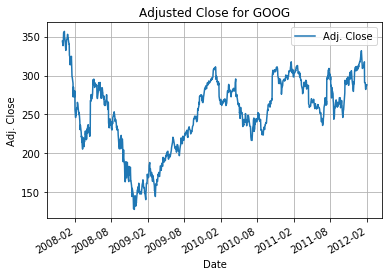

In [345]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime as dt
import pandas as pd

sd = dt.datetime(2007,11,30) 
ed = dt.datetime(2012,1,31)
syms=['GOOG']
dates = pd.date_range(sd, ed)
dfAdj = pd.DataFrame(index=dates)
dfAdj = pd.read_csv(syms[0] + '.csv', index_col="Date", parse_dates=True, usecols=['Date', 'Adj Close'],na_values=['NaN'])    # Reading files from the data/xxx.csv. Also replacing missing values with NANs
dfAdj.head()
dfAdj = dfAdj.rename(columns={'Adj Close': syms[0]})     # Renaming the Adj Close column to the symbol
# Forward Fill / Back Fill
dfAdj.fillna(method='ffill', inplace=True)
dfAdj.fillna(method='bfill', inplace=True)
dfAdj = dfAdj.dropna()
print(dfAdj.head())



pl1 = dfAdj.plot(y=syms[0],label='Adj. Close',title='Adjusted Close for '+syms[0],fontsize=10)
plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()
plt.show()


### <font color =blue>Operation 2: Feature Generation and Selection</font>
#### <font color =green>2a. Bollinger Bands</font>
Bollinger Bands is a technical analysis tool with two standard deviations sandwiching the Simple Moving Average (SMA) of a stock price. SMA is computed for a 20 day window along with the standard deviation for the same window. This band has three lines. 
1. The middle one for SMA values
2. The top and bottom ones are SMA +/- 2 standard deviations for the same moving window.
Typically, the average of first 20 days of data is considered for the 21st day average and the next days average is from day 2 to day 21 and so on. 

    - $ BU =SMA(Price,w) + 2* \sigma[Price,w]$
    - $ BL =SMA(Price,w) - 2* \sigma[Price,w]$
    - $ \sigma [Price,w]->$ Standard Deviation of the data in the window w
    - $ SMA(Price,w) ->$ Simple Moving Average
    
Further we normalize these values to bring the feature on the same scale as others. (Also called the 
[% B indicator](https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:bollinger_band_perce))
For the current work, additional one month data prior to the training window was considered inorder to accommodate a moving window for 20 days. Otherwise, around 20 data points are lost.

-0.8898154606581717
0.8928864025649155


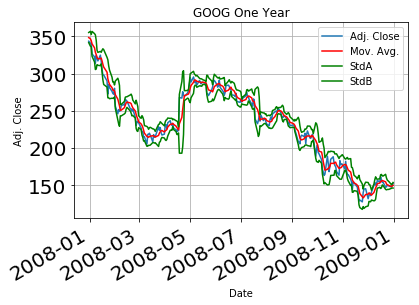

In [346]:
bolBand=pd.DataFrame()
wndwSize=5
bolBand['MVA_20']=dfAdj[syms[0]].rolling(window=wndwSize).mean()
bolBand['StdA_20']=bolBand['MVA_20']+2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['StdB_20']=bolBand['MVA_20']-2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['Std_20']=dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand[syms[0]]=dfAdj[syms[0]]
bolBand['BolNorm_20']=(bolBand[syms[0]]-bolBand['MVA_20'])/(2*bolBand['Std_20'])
print(bolBand['BolNorm_20'].min())
print(bolBand['BolNorm_20'].max())




mastData=bolBand
# We are reducing bolBand for visualizationin graphs
bolBand=bolBand.loc[dt.datetime(2007,12,31):dt.datetime(2008,12,31)]
ax=plt.figure(1)
ax=plt.gca()
bolBand.plot(y=syms[0],label='Adj. Close',title=syms[0],fontsize=20,ax=ax)
bolBand.plot(y='MVA_20',label='Mov. Avg.',title=syms[0],fontsize=20,color='red',ax=ax)
bolBand.plot(y='StdA_20',label='StdA',title=syms[0],fontsize=20,color='green',ax=ax)
bolBand.plot(y='StdB_20',label='StdB',title=syms[0] + ' One Year',fontsize=20,color='green',ax=ax)



plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()


#### <font color =green> 2b. Momentum </font>
Momentum indicates stock price strength. It indicates how fast or slow the stock prices change. It is just a difference of stock values over a window.
- Simply given as $ Momentum = P - P_n$
- where, P is current price and $P_n$ is the closing price before 'n' trading days.

In the current process, we considered momentum across various windows, expecting to use them as features for training our ML algorithms.
From the correlation values obtained below in results, momentum with 20 window was found to have a higher value, hence we plan to use a 20 point window for our ML training.

,Mom_05,Mom_10,Mom_20,GOOG
Mom_05,1.000000,0.699656,0.495837,0.088935
Mom_10,0.699656,1.000000,0.714575,0.130734
Mom_20,0.495837,0.714575,1.000000,0.215974
GOOG,0.088935,0.130734,0.215974,1.000000


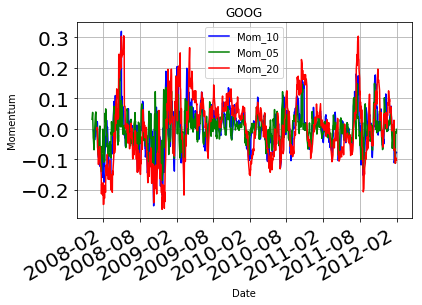

In [347]:
#print(bolBand['Date'])

mNSize=10;
mNSize1=5;
mNSize2=20;
momentum=mastData.reset_index()
momentum['Mom_10']=np.nan
momentum['Mom_05']=np.nan
momentum['Mom_20']=np.nan
momentum['Mom_01']=np.nan
for x in range(mNSize,momentum[syms[0]].count()):
    momentum.at[x,'Mom_10']= (momentum.loc[x,[syms[0]]])/ (momentum.loc[x-mNSize,[syms[0]]])-1
    
for x in range(mNSize1,momentum[syms[0]].count()):
    momentum.at[x,'Mom_05']= (momentum.loc[x,[syms[0]]]-momentum.loc[x-mNSize1,[syms[0]]])/ (momentum.loc[x-mNSize1,[syms[0]]])

for x in range(mNSize2,momentum[syms[0]].count()):
    momentum.at[x,'Mom_20']= (momentum.loc[x,[syms[0]]])/ (momentum.loc[x-mNSize2,[syms[0]]])-1
    
for x in range(mNSize2,momentum[syms[0]].count()):
    momentum.at[x,'Mom_01']= (momentum.loc[x,[syms[0]]])/ (momentum.loc[x-1,[syms[0]]])-1
#momentum=momentum.set_index('Date')



ax1=plt.figure(2)
ax1=plt.gca()


momentum=momentum.set_index('Date')
momentum.plot(y='Mom_10',label='Mom_10',title=syms[0],fontsize=20,color='blue',ax=ax1)
momentum.plot(y='Mom_05',label='Mom_05',title=syms[0],fontsize=20,color='green',ax=ax1)
momentum.plot(y='Mom_20',label='Mom_20',title=syms[0],fontsize=20,color='red',ax=ax1)

#mastData['Mom_20']=momentum['Mom_20']
mastData[['Mom_20','Mom_10','Mom_05']]=momentum[['Mom_20','Mom_10','Mom_05']]
plt.xlabel("Date")
plt.ylabel("Momentum")
plt.grid()
dfCorr=momentum[['Mom_05','Mom_10','Mom_20',syms[0]]]
dfCorr.corr(method='pearson')

Relative Strength Index

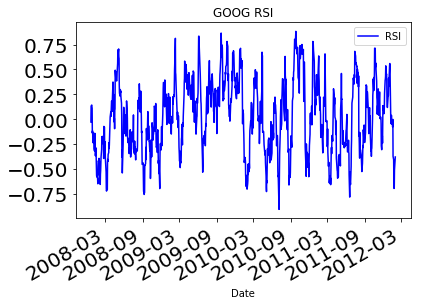

In [348]:
dfDummy=mastData
dfDummy=dfDummy.reset_index()
dfDummy=dfDummy[['Date',syms[0]]]
dfDummy['SD']=dfDummy[syms[0]].diff()
for x in range(1,dfDummy[syms[0]].count()):
    if dfDummy.loc[x,'SD']>=0:
        dfDummy.at[x,'Profits']=dfDummy.loc[x,'SD']
        dfDummy.at[x,'Loss']=0
    elif dfDummy.loc[x,'SD']<0:
        
        dfDummy.at[x,'Profits']=0
        dfDummy.at[x,'Loss']=abs(dfDummy.loc[x,'SD'])

dfDummy['ProfitAvg_14']=dfDummy['Profits'].rolling(window=14).sum()/14
dfDummy['LossAvg_14']=dfDummy['Loss'].rolling(window=14).sum()/14
dfDummy['RS_14']=dfDummy['ProfitAvg_14']/dfDummy['LossAvg_14']
dfDummy['RSI']=2*(1-1/(1+dfDummy['RS_14']))-1

axRSI=plt.figure(2)
axRSI=plt.gca()
dfDummy=dfDummy.set_index('Date')
dfDummy.plot(y='RSI',label='RSI',title=syms[0]+' RSI',fontsize=20,color='blue',ax=axRSI)
mastData['RSI_14']=dfDummy['RSI']
mastData['RS_14']=dfDummy['RS_14']
#dfDummy.plot(y=syms[0],label='IBM',title=syms[0]+' RSI',fontsize=20,color='blue',ax=axRSI)
#print(dfDummy)


                MVA_20     StdA_20     StdB_20    Std_20        GOOG  \
Date                                                                   
2007-11-30         NaN         NaN         NaN       NaN  344.260925   
2007-12-03         NaN         NaN         NaN       NaN  338.562988   
2007-12-04         NaN         NaN         NaN       NaN  339.869476   
2007-12-05         NaN         NaN         NaN       NaN  346.998108   
2007-12-06  345.002099  358.372881  331.631318  6.685391  355.319000   

            BolNorm_20  Mom_20  Mom_10  Mom_05  RSI_14  RS_14  Y_5  
Date                                                                
2007-11-30         NaN     NaN     NaN     NaN     NaN    NaN  NaN  
2007-12-03         NaN     NaN     NaN     NaN     NaN    NaN  NaN  
2007-12-04         NaN     NaN     NaN     NaN     NaN    NaN  NaN  
2007-12-05         NaN     NaN     NaN     NaN     NaN    NaN  NaN  
2007-12-06      0.7716     NaN     NaN     NaN     NaN    NaN  NaN  


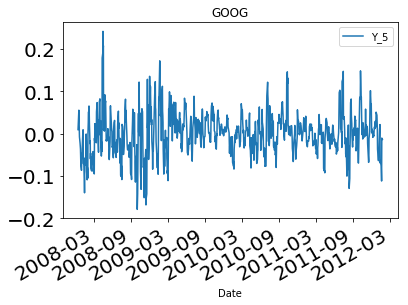

In [349]:
daysAhead=5;


mastData['Y_5']=np.nan
mastData=mastData.reset_index()
for x in range(mNSize,mastData[syms[0]].count()-daysAhead-1):
    mastData.at[x,'Y_5']= (mastData.loc[x+daysAhead,[syms[0]]])/ (mastData.loc[x,[syms[0]]])-1
ax2=plt.figure()
ax2=plt.gca()
mastData=mastData.set_index('Date')


print(mastData.head())
mastData.plot(y='Y_5',label='Y_5',title=syms[0],fontsize=20,ax=ax2)

Separating Data

In [350]:
dfTraining=mastData.loc[dt.datetime(2008,1,1):dt.datetime(2009,12,31)]
print(dfTraining.tail())
dfTraining=dfTraining.reset_index()
#dfTrainingX=dfTraining[['MVA Norm','Mom_01','Mom_20','Mom_10','Mom_05']]
dfTrainingX=dfTraining[['BolNorm_20','Mom_20','RS_14','RSI_14']]
dfTrainingY=dfTraining['Y_5']
print(dfTraining.describe())


dfTesting=mastData.loc[dt.datetime(2009,12,31):dt.datetime(2011,12,31)]
print(dfTesting.tail())
dfTesting=dfTesting.reset_index()
#dfTestingX=dfTesting[['MVA Norm','Mom_01','Mom_20','Mom_10','Mom_05']]
dfTestingX=dfTesting[['BolNorm_20','Mom_20','RS_14','RSI_14']]
dfTestingY=dfTesting['Y_5']
#print(dfTrainingX)
#print(dfTrainingY)
print(dfTestingX.tail())
print(dfTestingY.tail())

print('Training Features Shape:', dfTrainingX.shape)
print('Training Labels Shape:', dfTrainingY.shape)
print('Testing Features Shape:', dfTestingX.shape)
print('Training Labels Shape:', dfTestingY.shape)


                MVA_20     StdA_20     StdB_20    Std_20        GOOG  \
Date                                                                   
2009-12-24  300.682348  310.036464  291.328232  4.677058  307.241699   
2009-12-28  303.310260  313.798625  292.821895  5.244182  309.422516   
2009-12-29  305.368872  313.925207  296.812537  4.278168  307.698730   
2009-12-30  307.515912  312.038915  302.992908  2.261502  309.352966   
2009-12-31  308.340552  310.325532  306.355571  0.992490  307.986847   

            BolNorm_20    Mom_20    Mom_10    Mom_05    RSI_14     RS_14  \
Date                                                                       
2009-12-24    0.701226  0.055895  0.045613  0.041317  0.693390  5.522940   
2009-12-28    0.582765  0.074358  0.054800  0.044348  0.712173  5.948612   
2009-12-29    0.272296  0.062436  0.039733  0.034609  0.598076  3.976071   
2009-12-30    0.406158  0.055707  0.049887  0.035950  0.607934  4.101183   
2009-12-31   -0.178190  0.055267  0.037

Train Model

-0.00562485871398006
The coefficient for BolNorm_20 is -0.00562485871398006
The coefficient for Mom_20 is -0.0038395452986330855
The coefficient for RS_14 is -0.006568718560390943
The coefficient for RSI_14 is 0.03899155850288472
The intercept for our model is 0.009245712456329365
Training MSE is 0.043230122443665045
Testing MSE is 0.043230122443665045
       YP_5
0  0.009661
1  0.002294
2  0.007697
3  0.011952
4  0.005733


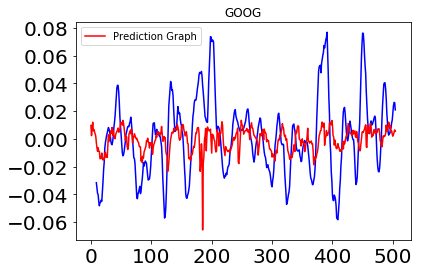

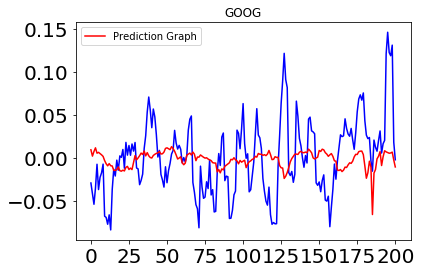

In [351]:
regression_model=LinearRegression()
regression_model.fit(dfTrainingX,dfTrainingY)
print(regression_model.coef_[0])
for idx, col_name in enumerate(dfTrainingX.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))
intercept=regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

regression_model.score(dfTrainingX,dfTrainingY)

from sklearn.metrics import mean_squared_error
y_predict=regression_model.predict(dfTestingX)
regression_model_mse=mean_squared_error(y_predict,dfTestingY)
regression_model_mse
import math
print("Training MSE is {}".format(math.sqrt(regression_model_mse)))


dfPredictedY = pd.DataFrame()
dfPredictedY['YP_5']=y_predict
dfTestingY1=dfTestingY.rolling(window=10).mean()


ax4=plt.figure()
ax4=plt.gca()


dfTestingY1.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax4)
dfPredictedY.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax4)



new_predict=regression_model.predict(dfTestingX)
regression_model_mse=mean_squared_error(new_predict,dfTestingY)
regression_model_mse
import math
print("Testing MSE is {}".format(math.sqrt(regression_model_mse)))


dfPredictedY1 = pd.DataFrame()
dfPredictedY1['YP_5']=y_predict

ax3=plt.figure()
ax3=plt.gca()

dfTestingY1=dfTestingY.loc[0:200]
dfPredictedY1=dfPredictedY.loc[0:200]
#dfPredictedY1=dfPredictedY1.shift(periods=5)
print(dfPredictedY1.head())
dfTestingY1.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax3)
dfPredictedY1.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax3)


Random Forest

Testing MSE is 0.05083662057115422
Mean Absolute Error: 0.04
-129.48343474230145
Accuracy 229.48 %.
       YP_5
0  0.044317
1  0.013878
2 -0.029151
3 -0.005914
4 -0.041721
   YP_5
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN


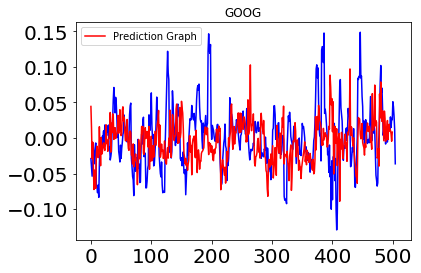

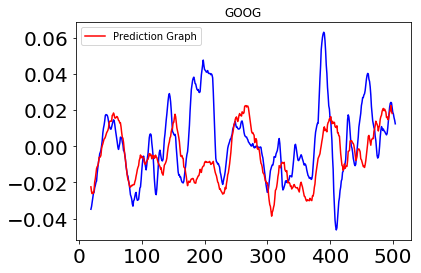

In [352]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(dfTrainingX,dfTrainingY)
predictions=rf.predict(dfTestingX)
#dfPred=pd.DataFrame(predictions)
#dfPred['predictions']=predictions


randomForest_model_mse=mean_squared_error(predictions,dfTestingY)
randomForest_model_mse
import math
print("Testing MSE is {}".format(math.sqrt(randomForest_model_mse)))
errors = abs(predictions - dfTestingY)
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = 100 * (errors / dfTestingY)

accuracy=100-np.mean(mape)
print(np.mean(mape))
print('Accuracy',round(accuracy,2),'%.')



dfPredictedY2 = pd.DataFrame()
dfPredictedY2['YP_5']=predictions

ax6=plt.figure()
ax6=plt.gca()

dfTestingY2=dfTestingY#.loc[0:200]
dfPredictedY2=dfPredictedY2#.loc[0:200]
dfPredictedY2=dfPredictedY2.shift(periods=-5)
print(dfPredictedY2.head())
dfTestingY2.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax6)
dfPredictedY2.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax6)



ax7=plt.figure()
ax7=plt.gca()

dfTestingY2=dfTestingY.rolling(window=20).mean()#.loc[0:200]
dfPredictedY2=dfPredictedY2.rolling(window=20).mean()#.loc[0:200]

print(dfPredictedY2.head())
dfTestingY2.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax7)
dfPredictedY2.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax7)

K nearest Neighbours



   YP_5
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN


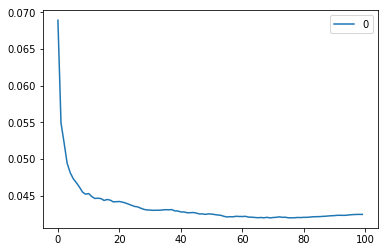

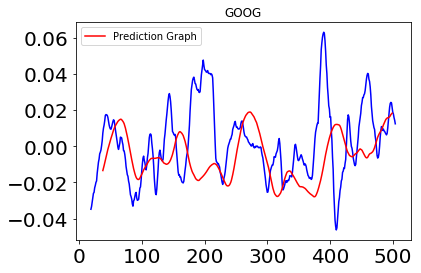

In [354]:
from sklearn import neighbors
from math import sqrt
rmse_val = [] #to store rmse values for different k
for K in range(100):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(dfTrainingX, dfTrainingY)  #fit the model
    pred=model.predict(dfTestingX) #make prediction on test set
    error = sqrt(mean_squared_error(dfTestingY,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    #print('RMSE value for k= ' , K , 'is:', error)
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()




axKNN=plt.figure()
axKNN=plt.gca()
dfPredictedYKNN=pd.DataFrame()
dfTestingYKNN=dfTestingY.rolling(window=20).mean()#.loc[0:200]
dfPredictedYKNN['Y_5']=pred#.loc[0:200]
dfPredictedYKNN=dfPredictedY2.rolling(window=20).mean()#.shift(periods=20)
print(dfPredictedY2.head())
dfTestingYKNN.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=axKNN)
dfPredictedYKNN.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=axKNN)
